In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skewnorm
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline

data = pd.read_csv('Churn_Modelling.csv')
data.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


# 2 Modèle simple
## 2.1 preprocessing
### 2.1.1 Age
Target encoding.

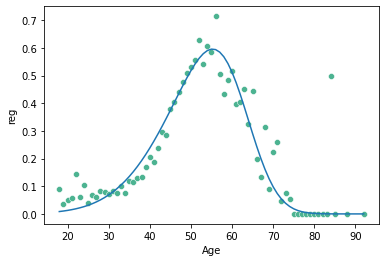

0.04604383430025527

In [5]:
mean, std_dev, skewness, coef = 37, 15, 2.3, 14.5

dt = data[['Age', 'Exited']].groupby('Age').mean().reset_index()
dt['reg'] = skewnorm.pdf(100 - dt.Age, a=skewness, loc=mean, scale=std_dev) *coef
sns.lineplot(x=dt.Age, y=dt.reg) 
sns.scatterplot(x=dt.Age, y=dt.Exited, color="#4CB391")
plt.show()

dt['resid'] = dt['reg'] - dt.Exited
dt['resid'].abs().mean()

In [6]:
data['f1_age'] = skewnorm.pdf(100 - data.Age, a=skewness, loc=mean, scale=std_dev) * coef

### 2.1.2 OneHotEncoding : Geography, Genre, Product, 

In [7]:
data['f2_isGermany'] = data['Geography'].apply(lambda x: x=='Germany') + 0
data['f3_gender'] = data['Gender'].apply(lambda x: x=='Male') + 0
data['f4_isActive'] = data['IsActiveMember'] + 0

### 2.1.3 OneHotEncoding : Product 

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder(sparse_output=False).fit(data[['NumOfProducts']])
df_5 = pd.DataFrame(encoder.transform(data[['NumOfProducts']]), columns=[x.replace('NumOfProducts', 'f5_product') for x in encoder.get_feature_names_out()])

data = pd.concat([data, df_5], axis=1) 

### 2.1.3 Balance

<AxesSubplot:xlabel='Balance', ylabel='Count'>

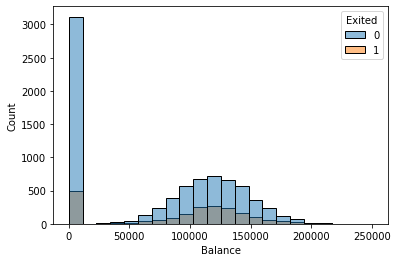

In [9]:
sns.histplot(data, x='Balance', hue='Exited')

In [10]:
mean_1 = int(data.query('Balance > 1 & Exited == 1').Balance.mean())
mean_0 = int(data.query('Balance > 1 & Exited == 0').Balance.mean())

stdev_1 = int(data.query('Balance > 1 & Exited == 1').Balance.std())
stdev_0 = int(data.query('Balance > 1 & Exited == 0').Balance.std())

print(f'mean_1 : {mean_1}')
print(f'mean_0 : {mean_0}')
print(f'stdev_1 : {stdev_1}')
print(f'stdev_0 : {stdev_0}')

mean_1 : 120746
mean_0 : 119535
stdev_1 : 30555
stdev_0 : 29944


In [11]:
data['f6_hasBalance'] = (data.Balance > 1) + 0

### 2.2 Modélisation
### 2.2.1 Compare Models

In [12]:
features = ['f1_age', 'f2_isGermany', 'f3_gender', 'f4_isActive', 'f5_product_2', 'f5_product_3', 'f5_product_4']
y = data.Exited 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# Create models
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Support Vector Machine', SVC(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42,  eval_metric='logloss', learning_rate=0.2, max_depth=3, n_estimators=200))]
 
def evaluate_model(name, model):
    steps = [('over', RandomOverSampler()), ('model', model)]
    pipeline = Pipeline(steps=steps)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    scores = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
    cv_score = round(np.mean(scores),3)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_score = round(f1_score(y_test, y_pred),3)
    print(f'{name} cross val score = {cv_score}, test score = {test_score}')
    return pd.Series([name, cv_score, test_score], index=['name', 'cv_score', 'test_score'])

df_perf = pd.DataFrame(models, columns=['name', 'model']).apply(lambda m: evaluate_model(m.name, m.model), axis=1)
df_perf

0 cross val score = 0.586, test score = 0.584
1 cross val score = 0.541, test score = 0.546
2 cross val score = 0.541, test score = 0.54


KeyboardInterrupt: 

### 2.2.1 Optimize Linear Model

In [14]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegression(C=1)
steps = [('over', RandomOverSampler()), ('model', model)]
def get_perf_C(C): 
    pipeline = Pipeline(steps=steps)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    scores = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
    cv_score = round(np.mean(scores),3)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_score = round(f1_score(y_test, y_pred),3) 
    return pd.Series([C, cv_score, test_score], index=['C', 'cv_score', 'test_score'])

df_lm = pd.DataFrame(range(100), columns=['i'])
df_lm['C'] = df_lm['i'] + 0.01
df_lm = df_lm['C'].apply(lambda c: get_perf_C(c))
df_lm

,C,cv_score,test_score
0,0.01,0.587,0.587
1,1.01,0.586,0.583
2,2.01,0.586,0.584
3,3.01,0.587,0.580
4,4.01,0.587,0.581
...,...,...,...
95,95.01,0.586,0.585
96,96.01,0.587,0.584
97,97.01,0.587,0.586
98,98.01,0.587,0.584


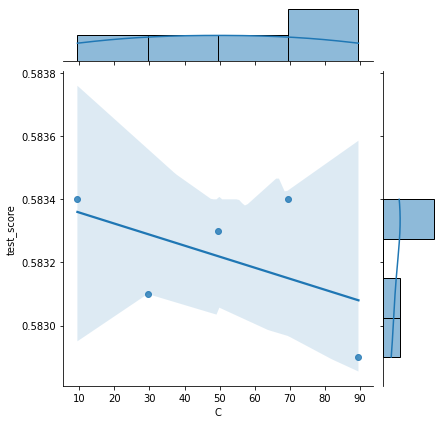

In [15]:
df_lm['C10'] = df_lm['C'].apply(lambda x: int(x/20)*20)
df_lmg = df_lm.groupby(['C10']).mean().reset_index()
sns.jointplot(data = df_lmg, kind="reg", x='C', y='test_score')

### 2.3 Predict

In [33]:
model = LogisticRegression(C=60)
steps = [('over', RandomOverSampler(sampling_strategy=1)), ('model', model)]
 
pipeline = Pipeline(steps=steps) 
pipeline.fit(data[features], y)
y_pred = pipeline.predict_proba(data[features])  
data['proba'] = [x[1] for x in y_pred]

In [37]:
y_pred = pipeline.predict(data[features])  
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      7963
           1       0.48      0.75      0.59      2037

    accuracy                           0.78     10000
   macro avg       0.70      0.77      0.72     10000
weighted avg       0.83      0.78      0.80     10000



In [39]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y, y_pred))

[[6298 1665]
 [ 504 1533]]


In [31]:
from sklearn.metrics import classification_report

# 2.4 Model Interpretation
### 2.4.1 Coeficients Interpretation

In [24]:
coefs = list(pipeline['model'].coef_.reshape(-1))
coefs.append(pipeline['model'].intercept_[0])

cols = features.copy()
cols.append('intercept')
d = pd.DataFrame(coefs, index=cols, columns=['coef'])
d['OR'] = d['coef'].apply(lambda x: np.exp(x))
d

,coef,OR
f1_age,5.404382,222.378652
f2_isGermany,0.883573,2.419530
f3_gender,-0.537281,0.584335
f4_isActive,-0.902922,0.405383
f5_product_2,-1.506177,0.221756
f5_product_3,2.599982,13.463496
f5_product_4,7.079260,1187.090117
intercept,-0.572905,0.563885


### 2.4.2 Archétypes

In [29]:
model = DecisionTreeClassifier(max_depth=4)
steps = [('over', RandomOverSampler()), ('model', model)]
 
pipeline = Pipeline(steps=steps) 
pipeline.fit(data[features], y)
tree_pred = pipeline.predict_proba(data[features])  
data['tree_proba'] = [x[1] for x in tree_pred]

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text 
  
r = export_text(pipeline['model'], feature_names=features)
print(r)

|--- f1_age <= 0.28
|   |--- f5_product_2 <= 0.50
|   |   |--- f5_product_3 <= 0.50
|   |   |   |--- f2_isGermany <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- f2_isGermany >  0.50
|   |   |   |   |--- class: 1
|   |   |--- f5_product_3 >  0.50
|   |   |   |--- f4_isActive <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- f4_isActive >  0.50
|   |   |   |   |--- class: 1
|   |--- f5_product_2 >  0.50
|   |   |--- f3_gender <= 0.50
|   |   |   |--- f1_age <= 0.13
|   |   |   |   |--- class: 0
|   |   |   |--- f1_age >  0.13
|   |   |   |   |--- class: 0
|   |   |--- f3_gender >  0.50
|   |   |   |--- f4_isActive <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- f4_isActive >  0.50
|   |   |   |   |--- class: 0
|--- f1_age >  0.28
|   |--- f5_product_2 <= 0.50
|   |   |--- f4_isActive <= 0.50
|   |   |   |--- f1_age <= 0.38
|   |   |   |   |--- class: 1
|   |   |   |--- f1_age >  0.38
|   |   |   |   |--- class: 1
|   |   |--- f4_isActive >  0.50
|   |   |   |--- f2_is

In [236]:
model = DecisionTreeClassifier(max_depth=3)
steps = [('over', RandomOverSampler()), ('model', model)]
 
pipeline = Pipeline(steps=steps) 
pipeline.fit(data[features], y)
tree_pred = pipeline.predict_proba(data[features])  
data['tree_proba'] = [x[1] for x in y_pred]

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text 
  
r = export_text(pipeline['model'], feature_names=features)

|--- Si Age entre 42 et 65 ans
|   |--- Si product 2 & has Balance
|   |   |   |--- CHURN
|   |   |--- Sinon
|   |   |   |--- OK
|--- Sinon 
|   |   |--- Si product 3 ou 4
|   |   |   |--- CHURN
|   |   |--- Sinon 
|   |   |   |--- OK

SyntaxError: invalid syntax (4076096220.py, line 14)

### 2.5 Check Calibration

In [237]:
data['proba_round'] = data['proba'].round(1)
datag = data[['proba_round', 'proba', 'Exited']].groupby('proba_round').mean().reset_index()
datag.columns = ['proba_round', 'estimated_proba', 'observed_frequency']
datag

,proba_round,estimated_proba,observed_frequency
0,0.0,0.039140,0.021531
1,0.1,0.099400,0.031431
2,0.2,0.197341,0.054847
3,0.3,0.297479,0.098174
4,0.4,0.400843,0.139446
5,0.5,0.498556,0.204234
6,0.6,0.600454,0.263238
7,0.7,0.699991,0.363176
8,0.8,0.799835,0.507640
9,0.9,0.899339,0.721600


<AxesSubplot:xlabel='estimated_proba'>

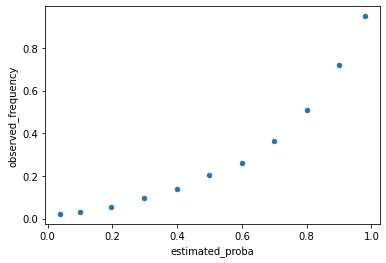

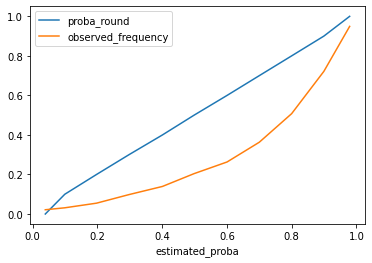

In [238]:
datag.plot.scatter('estimated_proba', 'observed_frequency')
datag.plot.line('estimated_proba')